In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [2]:
import torch

from molmo_video.model import MolmoForCausalLM
from molmo_video.preprocessor import MolmoProcessor
from molmo_video.config_molmo import MolmoConfig

In [3]:
model_id = "allenai/Molmo-7B-D-0924"

In [4]:
# load the processor
processor = MolmoProcessor.from_pretrained(
    model_id,
    # trust_remote_code=True,
    device_map='auto',
    # torch_dtype=torch.float16,
    torch_dtype='auto',
)

# load the model
model = MolmoForCausalLM.from_pretrained(
    model_id,
    # torch_dtype=torch.float16,
    torch_dtype='auto',
    device_map="auto",
)

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
from transformers import GenerationConfig
from PIL import Image

def run_molmo_inference(image_path=None, prompt='Describe this image.'):
    # process the image and text
    if image_path:
        inputs = processor.process(
            images=[Image.open(image_path)],
            # images=[Image.open(image_path), Image.open(image_path)], #TODO
            text=prompt
        )
    else:
        inputs = processor.process(
            text=prompt
        )

    # move inputs to the correct device and make a batch of size 1
    inputs = {k: v.to(model.device).unsqueeze(0) for k, v in inputs.items()}

    # generate output; maximum 200 new tokens; stop generation when <|endoftext|> is generated
    output = model.generate_from_batch(
        inputs,
        GenerationConfig(max_new_tokens=200, stop_strings='<|endoftext|>'),
        tokenizer=processor.tokenizer
    )

    # only get generated tokens; decode them to text
    generated_tokens = output[0,inputs['input_ids'].size(1):]
    generated_text = processor.tokenizer.decode(generated_tokens, skip_special_tokens=True)

    # print the generated text
    print(generated_text)
    return generated_text

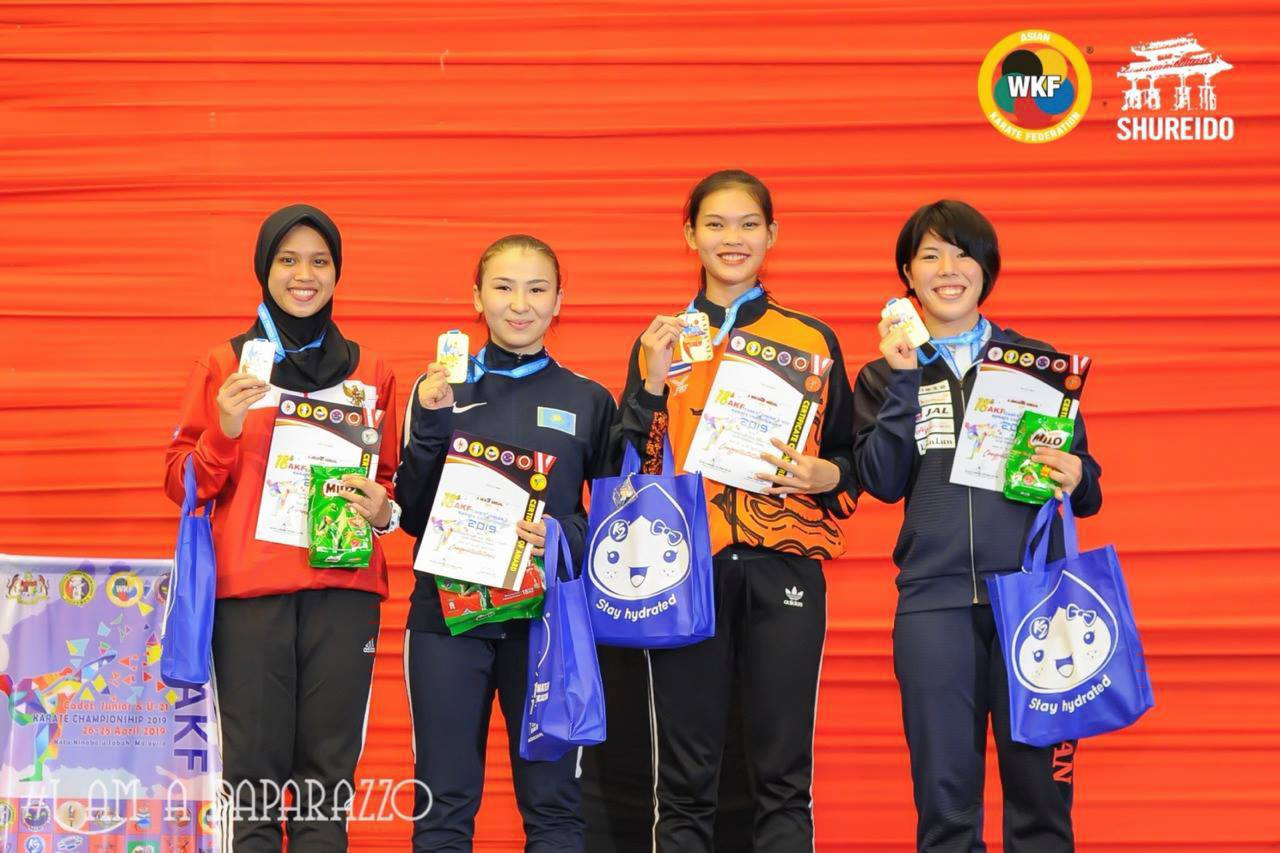

In [6]:
image_path = '../data/torch_datasets/pixmo_images/c0d2bd4805501b23e1cec10ef72a6047267d997bc3d5614892f5827dbb2d173e'
# show the image
Image.open(image_path)


In [8]:
# Pass the first frame to get the coordinates.
# video_frames_dir = '/share/users/shehan/workspace_pointing_lmm/SAM_Molmo_Whisper/experiments/video_frames'

# image_path = f'{video_frames_dir}/00000.jpg'

# outputs = run_molmo_inference(image_path=image_path, prompt="Point to the main player's shoes")

outputs = run_molmo_inference(image_path=image_path, prompt="Point to the girl wearing hijab")

>> images.shape torch.Size([1, 13, 576, 588])
>> image_features.shape torch.Size([1, 13, 576, 2048])
>> cls_embed.shape torch.Size([1, 13, 2048])
 <point x="23.0" y="41.0" alt="girl wearing hijab">girl wearing hijab</point>


In [7]:
outputs = run_molmo_inference(image_path=image_path, prompt="how many images are there?")

>> images.shape torch.Size([1, 26, 576, 588])
>> image_features.shape torch.Size([1, 26, 576, 2048])
>> cls_embed.shape torch.Size([1, 26, 2048])
 Counting the <points x1="2.0" y1="67.7" x2="5.1" y2="67.7" x3="7.9" y3="67.7" x4="10.6" y4="67.7" x5="12.9" y5="67.7" alt="images">images</points> shows a total of 5.


In [ ]:
# for name, module in model.named_modules():
#     print(name)

In [ ]:
from peft import LoraConfig, get_peft_model

# Define LoRA configuration. By setting target_modules to ["att_proj", "ff_proj"],
# only the transformer (LLM) portion will have LoRA adapters.
lora_config = LoraConfig(
    task_type="CAUSAL_LM",  # for causal language modeling
    r=8,                    # LoRA rank (adjust as needed)
    lora_alpha=32,          # scaling factor
    lora_dropout=0.1,       # dropout probability for LoRA layers
    target_modules=["att_proj", "ff_proj"]
)

# Wrap the model with LoRA (this only affects modules matching the target names)
model = get_peft_model(model, lora_config)

# Optional: print out trainable parameters to verify that only the LLM part is modified.
model.print_trainable_parameters()


In [ ]:
# # Optional: Freeze all parameters except those in LoRA adapters
# for name, param in model.named_parameters():
#     if "lora" not in name:
#         param.requires_grad = False

In [ ]:
from datasets import Dataset
import torch

def create_dummy_dataset():
    # Create dummy images using PIL (size can be adjusted as needed)
    dummy_images = [
        Image.new("RGB", (224, 224), color="red"),
        Image.new("RGB", (224, 224), color="green"),
        Image.new("RGB", (224, 224), color="blue"),
        Image.new("RGB", (224, 224), color="yellow"),
    ]
    # Dummy questions and answers
    dummy_questions = [
        "What is shown in the image?",
        "Describe the scene.",
        "What color dominates the image?",
        "What object is visible?",
    ]
    dummy_answers = [
        "A red object is displayed.",
        "A scene with greenery is shown.",
        "Blue hues are dominant.",
        "A yellow object is visible.",
    ]
    # Build a dictionary
    data = {
        "image": dummy_images,
        "question": dummy_questions,
        "answer": dummy_answers,
    }
    # Create a Hugging Face Dataset
    dataset = Dataset.from_dict(data)
    return dataset

def preprocess_function(example, processor, tokenizer):
    """
    For each example, we combine the question and answer into one text prompt.
    The processor will process the image and the text.
    Adjust the prompt formatting as needed.
    """
    # Create the text prompt.
    # For instance, we use a format where the model sees the question and then the answer.
    prompt = f"Question: {example['question']} Answer: {example['answer']}"
    
    # Use the processor to process both image and text.
    # The processor should handle images and tokenize the text.
    # encoding = processor(image=example["image"], text=prompt, return_tensors="pt")
    encoding = processor.process(image=example["image"], text=prompt, return_tensors="pt")
    
    # Remove the batch dimension (squeeze out first dim) because we map per example.
    encoding = {k: v.squeeze(0) for k, v in encoding.items()}
    return encoding

def custom_data_collator(features, tokenizer):
    """
    Collate a list of preprocessed examples into a batch.
    For the text fields, we use the tokenizer's pad method if they exist.
    For the image tensors (assumed under the key "pixel_values"), we stack them.
    """
    # Prepare dictionary for text features.
    text_features = {}
    # Check for input_ids and attention_mask in the first feature.
    if "input_ids" in features[0]:
        text_features["input_ids"] = [feature["input_ids"] for feature in features]
    if "attention_mask" in features[0]:
        text_features["attention_mask"] = [feature["attention_mask"] for feature in features]

    # Use tokenizer.pad only if we have text features.
    if text_features:
        padded_text = tokenizer.pad(text_features, return_tensors="pt")
    else:
        padded_text = {}

    # Stack image features if available.
    if "pixel_values" in features[0]:
        images = torch.stack([feature["pixel_values"] for feature in features])
        padded_text["pixel_values"] = images

    return padded_text


In [ ]:
from transformers import AutoTokenizer, TrainingArguments, Trainer
tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)

In [ ]:
raw_dataset = create_dummy_dataset()

# Preprocess the dataset.
# Use a lambda so that we can pass our processor and tokenizer.
processed_dataset = raw_dataset.map(
    lambda x: preprocess_function(x, processor, tokenizer),
    batched=False
)

# ---------------------------
# 5. Training Arguments Setup
# ---------------------------
training_args = TrainingArguments(
    output_dir="./lora_molmo_multimodal",
    per_device_train_batch_size=1,  # Adjust based on available GPU memory.
    gradient_accumulation_steps=4,    # Effective batch size multiplier.
    num_train_epochs=3,
    learning_rate=2e-4,
    fp16=True,
    logging_steps=5,
    save_steps=50,
    evaluation_strategy="no",
    save_total_limit=2,
)

# ---------------------------
# 6. Initialize Trainer
# ---------------------------
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=processed_dataset,
    data_collator=lambda features: custom_data_collator(features, tokenizer),
)

# ---------------------------
# 7. Start Training
# ---------------------------
trainer.train()

# Save the final model (LoRA adapters will be saved)
model.save_pretrained(training_args.output_dir)